In [291]:
import warnings
warnings.filterwarnings("ignore")

In [292]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Preprocessing
from math import cos, sin
from sklearn.preprocessing import OneHotEncoder

# LR
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, accuracy_score

# K-Means
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score

In [293]:
# Load dataset

initial_dataset = pd.read_csv('House_Price_Prediction.csv')
initial_dataset.shape

(29451, 12)

In [294]:
initial_dataset.head()

,POSTED_BY,UNDER_CONSTRUCTION,RERA,BHK_NO.,BHK_OR_RK,SQUARE_FT,READY_TO_MOVE,RESALE,ADDRESS,LONGITUDE,LATITUDE,TARGET(PRICE_IN_LACS)
0,Owner,0,0,2,BHK,1300.236407,1,1,"Ksfc Layout,Bangalore",12.969910,77.597960,55.0
1,Dealer,0,0,2,BHK,1275.000000,1,1,"Vishweshwara Nagar,Mysore",12.274538,76.644605,51.0
2,Owner,0,0,2,BHK,933.159722,1,1,"Jigani,Bangalore",12.778033,77.632191,43.0
3,Owner,0,1,2,BHK,929.921143,1,1,"Sector-1 Vaishali,Ghaziabad",28.642300,77.344500,62.5
4,Dealer,1,0,2,BHK,999.009247,0,1,"New Town,Kolkata",22.592200,88.484911,60.5


## Preprocessing

1. Removes irrelevant fields
2. Handles categorial variables
3. Converts latitude-longitude to xyz coordinates (for further clustering in next step)

In [295]:
# Remove unnecessary and overwritten columns

def cleanDF(data):
    clean_df = data.drop(['POSTED_BY', 'RERA', 'BHK_OR_RK', 'ADDRESS', 'LONGITUDE', 'LATITUDE'], axis=1, errors='ignore')
    return clean_df

In [296]:
# Handle categorical variables using OneHotEncoder
# : Generates new boolean fields based off possible categories of categorial variables

def handleCategoricalVariables(data):
    encoder = OneHotEncoder(handle_unknown='ignore')
    encoded_data = encoder.fit_transform(data[['POSTED_BY', 'BHK_OR_RK']])
    column_names = encoder.get_feature_names_out(['POSTED_BY', 'BHK_OR_RK'])
    encoded_df = pd.DataFrame.sparse.from_spmatrix(encoded_data, columns=column_names)
    return encoded_df

In [297]:
# Converts latitute and longitude to 3D coordinates (x,y,z)

def get3DCoordinatesFromLatLong(lat, long):
    # If latitude and longitude are as strings
    # lat = (int)((lat.strip())[1:].split('°')[0])
    # long = (int)((long.strip())[1:].split('°')[0])

    r = 10000
    x = r * sin(lat) * cos(long)
    y = r * sin(lat) * sin(long)
    z = r * cos(lat)

    return (x, y, z)

In [298]:
# Preprocess dataset

def preprocessDF(data):
    cl_df = cleanDF(data)
    cl_df.rename(columns={'TARGET(PRICE_IN_LACS)': 'PRICE_IN_LACS'}, inplace=True)
    
    x = []
    y = []
    z = []
    for i in range(data.shape[0]):
        xyz = get3DCoordinatesFromLatLong(data.iloc[i,:]['LATITUDE'], data.iloc[i,:]['LONGITUDE'])
        x.append(xyz[0])
        y.append(xyz[1])
        z.append(xyz[2])
    cl_df['X'] = x
    cl_df['Y'] = y
    cl_df['Z'] = z

    cv_df = handleCategoricalVariables(data)

    processed_df = pd.concat([cl_df, cv_df], axis=1)

    return processed_df

In [299]:
processed_dataset = preprocessDF(initial_dataset)
processed_dataset.head()

,UNDER_CONSTRUCTION,BHK_NO.,SQUARE_FT,READY_TO_MOVE,RESALE,PRICE_IN_LACS,X,Y,Z,POSTED_BY_Builder,POSTED_BY_Dealer,POSTED_BY_Owner,BHK_OR_RK_BHK,BHK_OR_RK_RK
0,0,2,1300.236407,1,1,55.0,7436.981766,3175.379663,-5882.879075,0.0,0.0,1.0,1.0,0.0
1,0,2,1275.000000,1,1,51.0,9077.611114,-2727.002340,3187.543679,0.0,1.0,0.0,1.0,0.0
2,0,2,933.159722,1,1,43.0,7704.573157,1655.566148,-6156.188204,0.0,0.0,1.0,1.0,0.0
3,0,2,929.921143,1,1,62.5,-8680.561413,-3346.574721,-3667.191185,0.0,0.0,1.0,1.0,0.0
4,1,2,999.009247,0,1,60.5,-4100.243098,-2811.460662,8676.617745,0.0,1.0,0.0,1.0,0.0


In [300]:
X = processed_dataset
Y = processed_dataset['PRICE_IN_LACS']

In [301]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, shuffle=True)

## Clustering
Clusters houses based off there xyz coordinates to seperate out localities 

In [302]:
X_train_xyz = X_train.loc[:,['X', 'Y', 'Z']]

In [303]:
# Find optimal k for KMeans clustering using Davies Bouldin score and Elbow method

k_optimal = 1
db_min = 1000

inertia = {}
db = {}
for k in range(2,50):
    kmeans = KMeans(n_clusters=k, max_iter=10000, random_state=322)
    kmeans.fit(X_train_xyz)
    labels = kmeans.predict(X_train_xyz)

    inertia[k] = kmeans.inertia_
    db[k] = davies_bouldin_score(X_train_xyz, labels)
    
    if db[k] < db_min:
        db_min = db[k]
        k_optimal = k

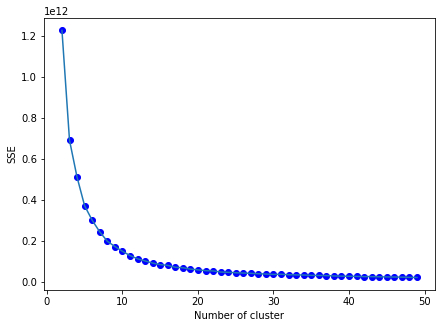

In [304]:
plt.figure(figsize=(7,5))
plt.plot(list(inertia.keys()), list(inertia.values()),'bo')
plt.plot(list(inertia.keys()), list(inertia.values()))
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.show()

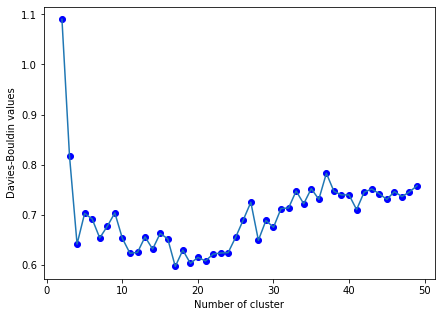

In [305]:
plt.figure(figsize=(7,5))
plt.plot(list(db.keys()), list(db.values()), 'bo')
plt.plot(list(db.keys()), list(db.values()))
plt.xlabel("Number of cluster")
plt.ylabel("Davies-Bouldin values")
plt.show()

In [306]:
# Clustering into k_optimal localities

kmeans = KMeans(n_clusters=k_optimal, max_iter=100000, random_state=322)
kmeans.fit(X_train_xyz)
labels = kmeans.predict(X_train_xyz)

X_train['LOCALITY_ID'] = labels

In [307]:
# Adding LOCALITY_ID for each house in training dataset

localities = []
for locality_id in range(k_optimal):
    localities.append(X_train[X_train['LOCALITY_ID'] == locality_id])

## Linear Regression with Clustering
Train different linear regression models for every locality

In [308]:
locality_LR = []
locality_LR_r2_score = []

for locality in localities:
    x = locality.drop(['LOCALITY_ID', 'X', 'Y', 'Z', 'PRICE_IN_LACS'], axis=1)
    y = locality['PRICE_IN_LACS']

    linear_reg = LinearRegression()
    linear_reg.fit(x, y)
    locality_LR.append(linear_reg)

    y_pred = linear_reg.predict(x)
    locality_LR_r2_score.append(r2_score(y, y_pred))

### Prediction

In [309]:
X_test_df = X_test.drop(['X', 'Y', 'Z', 'PRICE_IN_LACS'], axis=1)
price_predictions = {}

In [310]:
# Predicting price of a house in each locality based off the linear regression models trained for localities

for locality_id, lr in enumerate(locality_LR):
    price_predictions[f'LOCALITY_{locality_id}_PRICE'] = lr.predict(X_test_df)

In [311]:
price_predictions_df = pd.DataFrame(price_predictions)
price_predictions_df

,LOCALITY_0_PRICE,LOCALITY_1_PRICE,LOCALITY_2_PRICE,LOCALITY_3_PRICE,LOCALITY_4_PRICE,LOCALITY_5_PRICE,LOCALITY_6_PRICE,LOCALITY_7_PRICE,LOCALITY_8_PRICE,LOCALITY_9_PRICE,LOCALITY_10_PRICE,LOCALITY_11_PRICE,LOCALITY_12_PRICE,LOCALITY_13_PRICE,LOCALITY_14_PRICE,LOCALITY_15_PRICE,LOCALITY_16_PRICE
0,38.171724,38.989174,31.165810,43.789969,41.783140,67.031054,39.891523,26.057064,54.143527,15.520152,36.232043,35.762218,42.489207,37.174023,38.806766,26.359693,40.106036
1,50.293198,57.149935,42.142723,43.831936,41.779282,109.286891,53.073050,26.446295,85.571833,15.557299,43.433743,42.851343,60.011464,59.708291,38.878576,40.377164,51.687396
2,64.129672,62.520376,34.561634,83.872741,41.755701,192.134465,44.392426,55.958698,77.224507,80.138228,52.805849,79.635203,50.599016,38.423535,54.741745,69.535436,64.529448
3,36.805720,43.764084,-20.920553,123.956104,68.501422,160.083180,33.736655,57.251957,43.496197,117.363198,41.479477,47.014330,52.011326,13.526641,82.724566,55.664671,46.173252
4,42.434355,45.375579,35.025946,43.804727,41.781783,81.890721,44.526932,26.193941,65.195589,15.533215,38.764589,38.255176,48.651075,45.098413,38.832018,31.289070,44.178732
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7358,62.529862,49.100078,113.689887,76.054409,58.727734,167.232397,41.071844,42.659122,56.205076,160.514902,52.389621,94.502670,37.688830,30.394938,60.751065,60.659550,67.915936
7359,65.048476,86.078239,4.655403,124.053887,68.492432,258.538311,64.449309,58.158857,116.723429,117.449749,58.259273,63.531829,92.837783,66.030969,82.891881,88.325057,73.157555
7360,53.558686,79.887300,-86.326475,131.826900,51.524565,237.809622,53.535574,71.038115,103.804415,37.032962,50.898610,41.009037,86.826232,49.725515,76.805017,82.063915,57.264718
7361,129.069959,155.613971,123.097646,156.455651,85.424401,497.007313,108.761631,76.034540,221.623274,262.566049,97.981933,145.468998,145.372953,132.987509,105.071153,168.492255,138.863462


### Predicting the price of a house in most suitable locality

In [312]:
X_test_xyz = X_test.loc[:,['X', 'Y', 'Z']]

# Predicting locality of a house in test dataset using KMeans clustering
X_test_locality_id = kmeans.predict(X_test_xyz)
X_test['LOCALITY_ID'] = X_test_locality_id

# Predicting price of a house in test dataset using linear regression models trained for localities
test_price_predictions = []
for i in range(X_test.shape[0]):
    test_price_predictions.append(price_predictions[f'LOCALITY_{int(X_test_locality_id[i])}_PRICE'][i])

X_test['PRICE_PREDICTION'] = test_price_predictions
test_data_frame = pd.concat([X_test['PRICE_PREDICTION'], y_test], axis=1)
test_data_frame.head(10)

,PRICE_PREDICTION,PRICE_IN_LACS
11418,41.783140,45.0
26257,59.708291,55.0
20988,77.224507,67.2
15762,68.501422,38.0
9157,43.804727,80.0
22958,124.045992,43.0
27203,24.737536,45.0
13369,108.742500,220.0
2511,305.854918,290.0
4625,76.143944,51.5


### R2 Score

In [313]:
print(f"R2 score [with clustering]: {r2_score(y_test, test_price_predictions)}")

R2 score [with clustering]: 0.6072296235525041


## Linear Regression without Clustering
Train a single linear regression model for all localities

In [314]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, shuffle=True)
X_train_df = X_train.drop(['X', 'Y', 'Z', 'PRICE_IN_LACS'], axis=1)
X_test_df = X_test.drop(['X', 'Y', 'Z', 'PRICE_IN_LACS'], axis=1)

In [315]:
# Linear regression without clustering
linear_reg = LinearRegression()
linear_reg.fit(X_train_df, y_train)
y_pred = linear_reg.predict(X_test_df)

print(f"R2 score [without clustering]: {r2_score(y_test, y_pred)}")

R2 score [without clustering]: -0.39678250723407626
